In [2]:
import pandas as pd
from gurobipy import *

#input parameters
FILE_PATH = "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2024.csv"
FIXED_PRICE = 0.289  # €/kWh (fixed contract incl. taxes)
POWER_KW = 7.4       # charging power (1-phase wallbox)
CHARGE_START = 18    # start hour
CHARGE_END = 7       # end hour
TAX_SURCHARGE = 0.10880
BTW = 1.21

#data set
df = pd.read_csv(FILE_PATH, sep=";", decimal=",")
df["datum_nl"] = pd.to_datetime(df["datum_nl"])
df["hour"] = df["datum_nl"].dt.hour
df["weekday"] = df["datum_nl"].dt.day_name()

# apply btw and taxes
df["prijs_incl_belastingen"] = (df["prijs_excl_belastingen"] + TAX_SURCHARGE) * BTW


# function per scenario
def calculate_scenario(name, active_days, energy_kwh_per_day):
    needed_hours = int(energy_kwh_per_day / POWER_KW)

    # Select charging window between 18:00 and 07:00
    df_charge = df[(df["hour"] >= CHARGE_START) | (df["hour"] < CHARGE_END)].copy()

    # Keep only active days 
    if active_days:
        df_charge = df_charge[df_charge["weekday"].isin(active_days)]

    # Select the first hours charging immediatly
    all_days = sorted(df_charge["datum_nl"].dt.date.unique())

    charged_rows = []
    optimized_daily_costs = []
    optimized_hours = []

    for i in range(len(all_days) - 1):
        today = all_days[i]
        tomorrow = all_days[i + 1]

        # Choosing time window between 18 and 07 next day
        window_today = df[(df["datum_nl"].dt.date == today) & (df["hour"] >= CHARGE_START)]
        window_next = df[(df["datum_nl"].dt.date == tomorrow) & (df["hour"] < CHARGE_END)]
        window = pd.concat([window_today, window_next]).sort_values("datum_nl")

        # charge immediately (non-optimized)
        charged_rows.append(window.iloc[:needed_hours])

        # optimization model
        timesteps = range(len(window))
        prices = {t: window.iloc[t]["prijs_incl_belastingen"] for t in timesteps}

        model = Model()
        charge = model.addVars(timesteps, lb=0, ub=POWER_KW)  # adding decision variable

        # The total amount charged needs to be the same as the amount of energy needed
        model.addConstr(sum(charge[t] for t in timesteps) == energy_kwh_per_day)

        # Objective: minimize cost
        model.setObjective(sum(prices[t] * charge[t] for t in timesteps), GRB.MINIMIZE)
        model.setParam("OutputFlag", 0)
        model.optimize()

        optimized_daily_costs.append(model.objVal)

        for t in timesteps:
            if charge[t].X > 0:  # if charging occurs
                optimized_hours.append(window.iloc[t]["datum_nl"].hour)


    # Combine all non-optimized charging rows
    df_nonopt = pd.concat(charged_rows)

    # Calculate non-optimized costs
    df_nonopt["cost_dynamic"] = df_nonopt["prijs_incl_belastingen"] * POWER_KW
    df_nonopt["cost_fixed"] = FIXED_PRICE * POWER_KW

    daily_costs = df_nonopt.groupby(df_nonopt["datum_nl"].dt.date)[["cost_dynamic", "cost_fixed"]].sum()
    total_dynamic = daily_costs["cost_dynamic"].sum()
    total_fixed = daily_costs["cost_fixed"].sum()

    # Calculate optimized totals
    total_optimized = sum(optimized_daily_costs)
    diff_opt_vs_fixed = total_optimized - total_fixed
    diff_opt_vs_dyn = total_optimized - total_dynamic

    # The following code is for visualisations
    # Combine all non-optimized charging rows
    df_nonopt = pd.concat(charged_rows)

    # Calculate non-optimized and fixed costs
    df_nonopt["cost_dynamic"] = df_nonopt["prijs_incl_belastingen"] * POWER_KW
    df_nonopt["cost_fixed"] = FIXED_PRICE * POWER_KW

    # Aggregate by date
    df_daily = (
        df_nonopt.groupby(df_nonopt["datum_nl"].dt.date)[["cost_dynamic", "cost_fixed"]]
        .sum()
        .reset_index()
        .rename(columns={"datum_nl": "date"})
    )
    df_daily["scenario"] = name

    # Calculate optimized daily cost sequence (for visualization)
    df_daily_opt = df_daily.copy()
    df_daily_opt["cost_optimized"] = optimized_daily_costs[: len(df_daily)]

    return {
        "Scenario": name,
        "Active days": ", ".join(active_days) if active_days else "Every day",
        "Energy/day (kWh)": energy_kwh_per_day,
        "Total dynamic (€)": total_dynamic,
        "Total fixed (€)": total_fixed,
        "Total optimized (€)": total_optimized,
        "Opt - fixed (€)": diff_opt_vs_fixed,
        "Opt - dyn (€)": diff_opt_vs_dyn,
        "Optimized hours": optimized_hours,
        "Daily data": df_daily_opt, 
    }


scenarios = [
    ("Distant commuter", [], 29.6),                      # daily
    ("City hopper", [], 7.4),                            # daily
    ("Road tripper", ["Saturday", "Sunday"], 29.6),      # weekends
    ("Grocery grabber", ["Wednesday", "Sunday"], 7.4)    # twice per week
]

# results
results = [calculate_scenario(*s) for s in scenarios]
df_results = pd.DataFrame(results)

# save file
df_results.to_csv("scenario_costs_2024_optimized.csv", index=False)
print("Results saved to 'scenario_costs_2024_optimized.csv'")

# results printed
print(f"\n{'Scenario':<20} {'Active days':<25} {'Energy/day (kWh)':>17} "
      f"{'Total dynamic (€)':>20} {'Total fixed (€)':>20} {'Total optimized (€)':>23} "
      f"{'Opt - fixed (€)':>20} {'Opt - dyn (€)':>20}")
print("-" * 170)

for r in results:
    print(f"{r['Scenario']:<20} {r['Active days']:<25} {r['Energy/day (kWh)']:>17.1f} "
          f"{r['Total dynamic (€)']:>20.2f} {r['Total fixed (€)']:>20.2f} {r['Total optimized (€)']:>23.2f} "
          f"{r['Opt - fixed (€)']:>20.2f} {r['Opt - dyn (€)']:>20.2f}")


Set parameter Username
Set parameter LicenseID to value 2718287
Academic license - for non-commercial use only - expires 2026-10-06
Results saved to 'scenario_costs_2024_optimized.csv'

Scenario             Active days                Energy/day (kWh)    Total dynamic (€)      Total fixed (€)     Total optimized (€)      Opt - fixed (€)        Opt - dyn (€)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distant commuter     Every day                              29.6              2865.14              3122.36                 2256.47              -865.89              -608.67
City hopper          Every day                               7.4               710.26               780.59                  550.45              -230.14              -159.80
Road tripper         Saturday, Sunday                       29.6               742.95               881.10                  

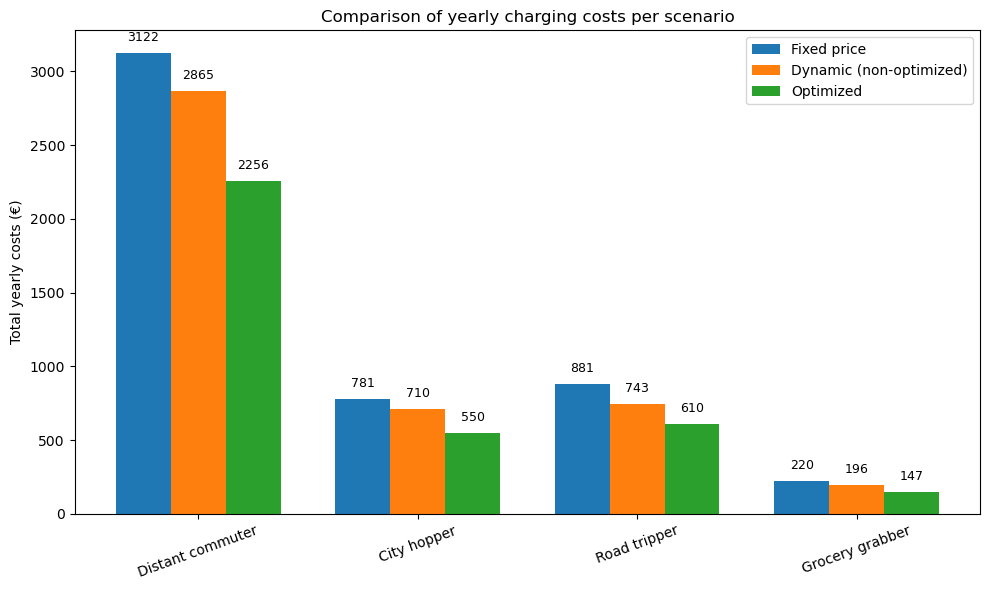

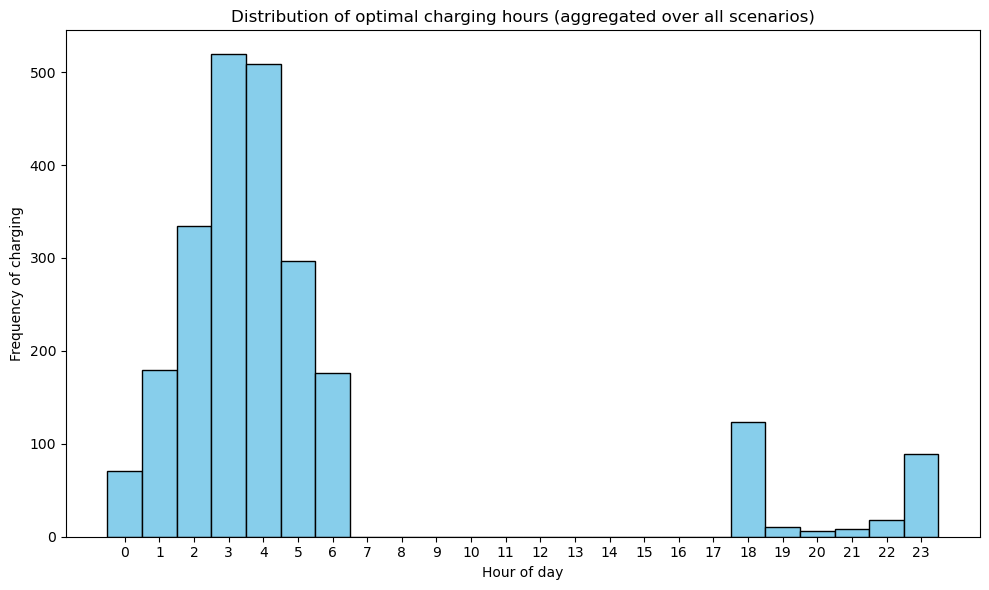

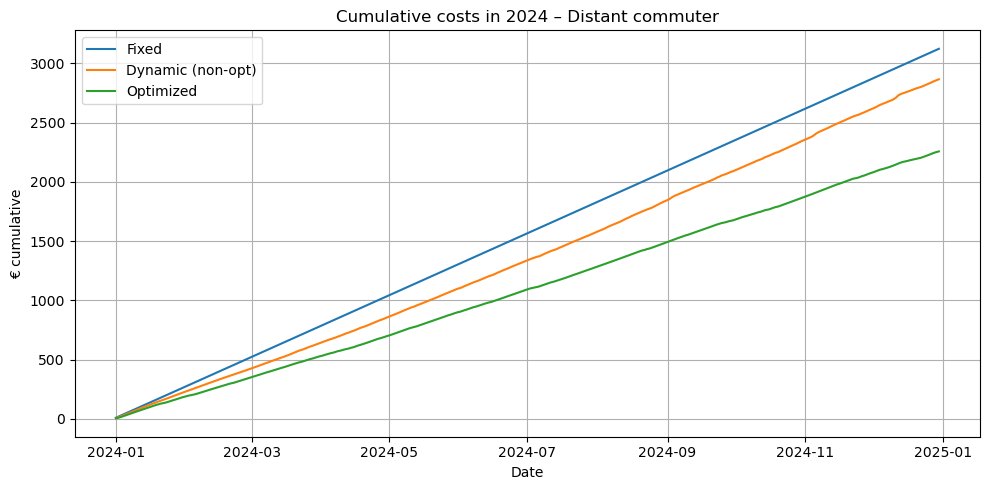

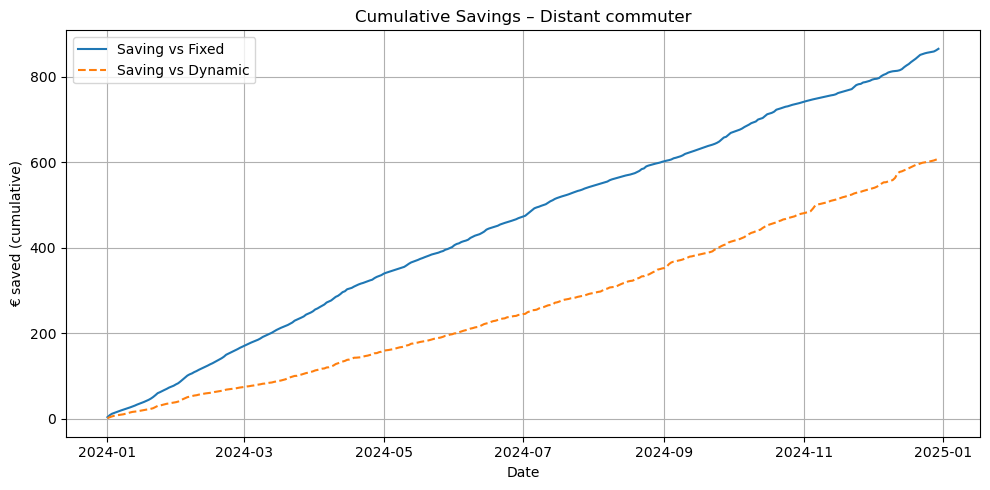

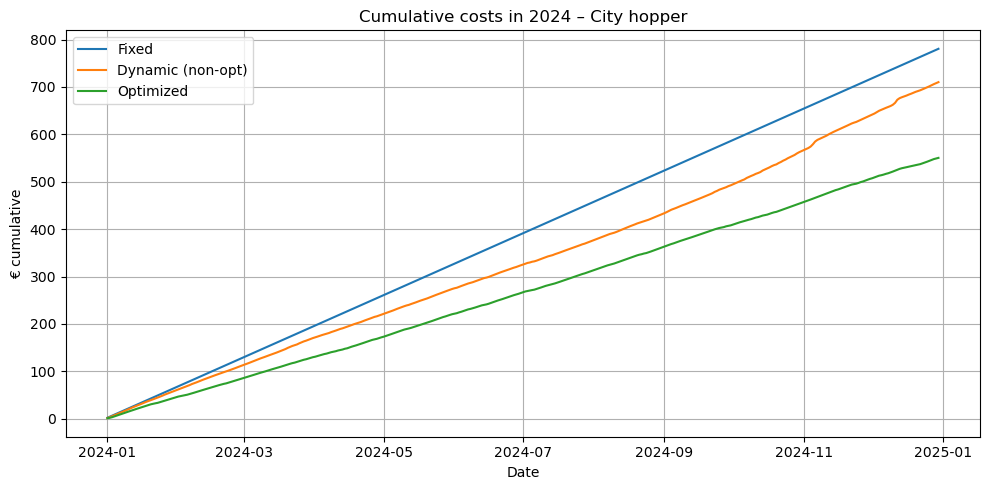

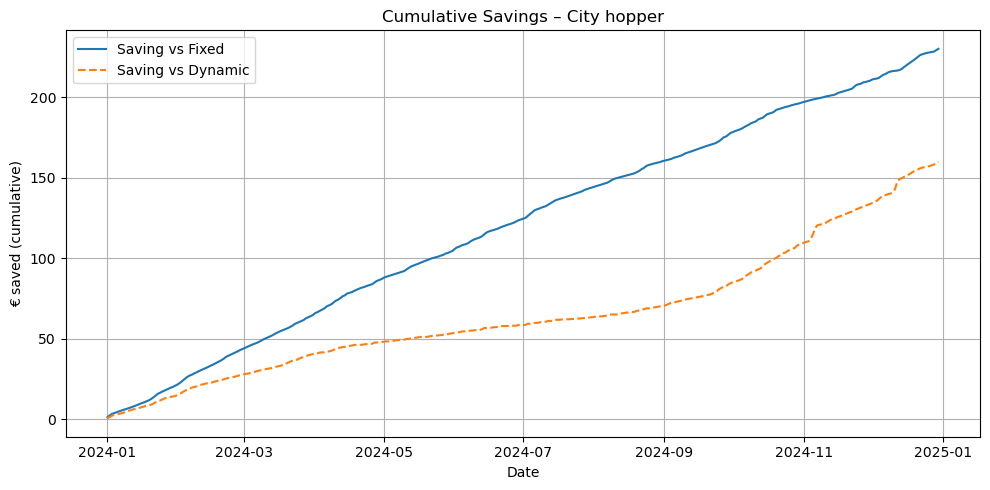

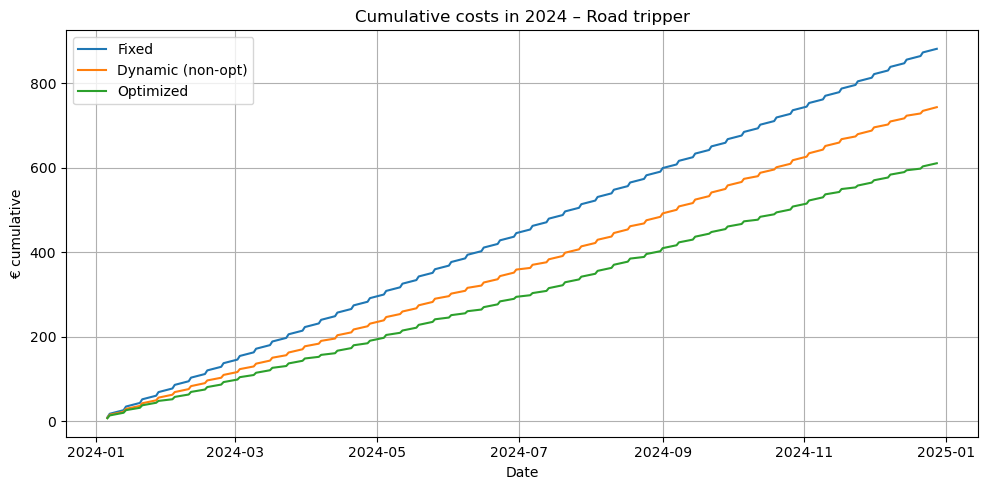

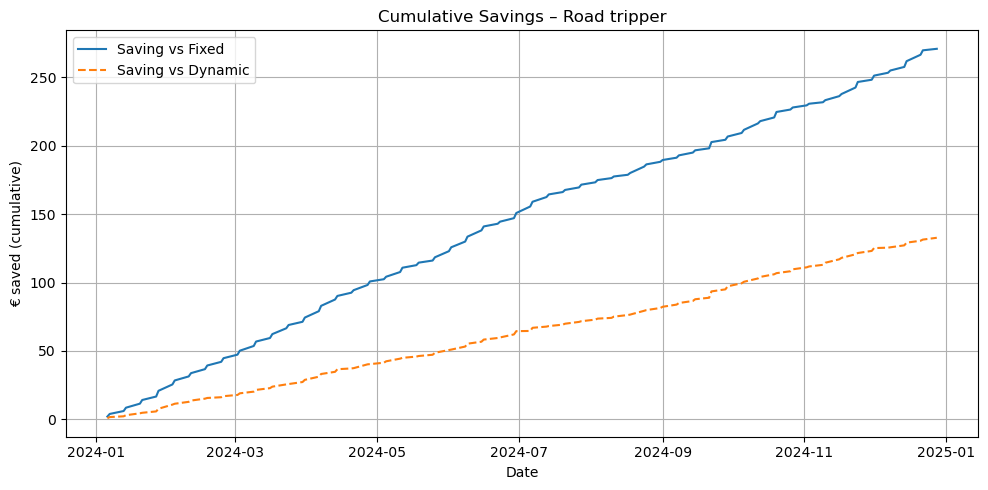

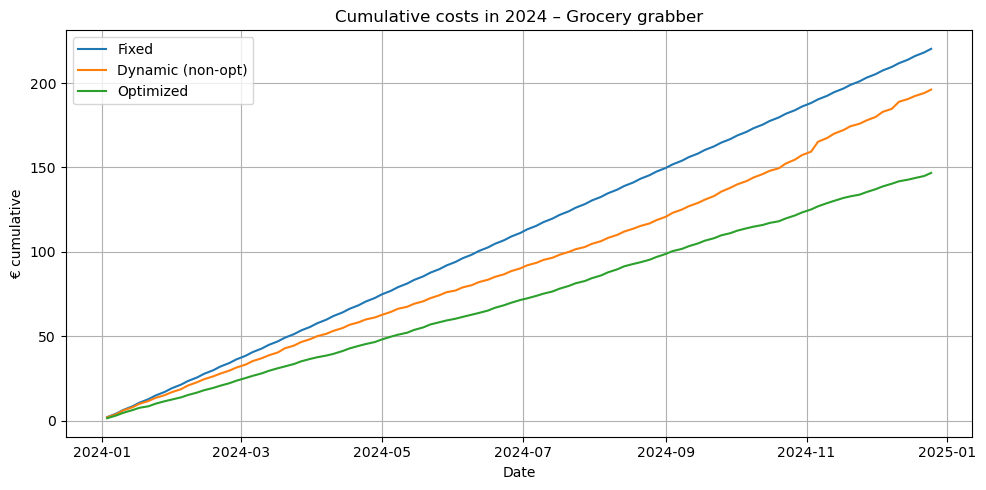

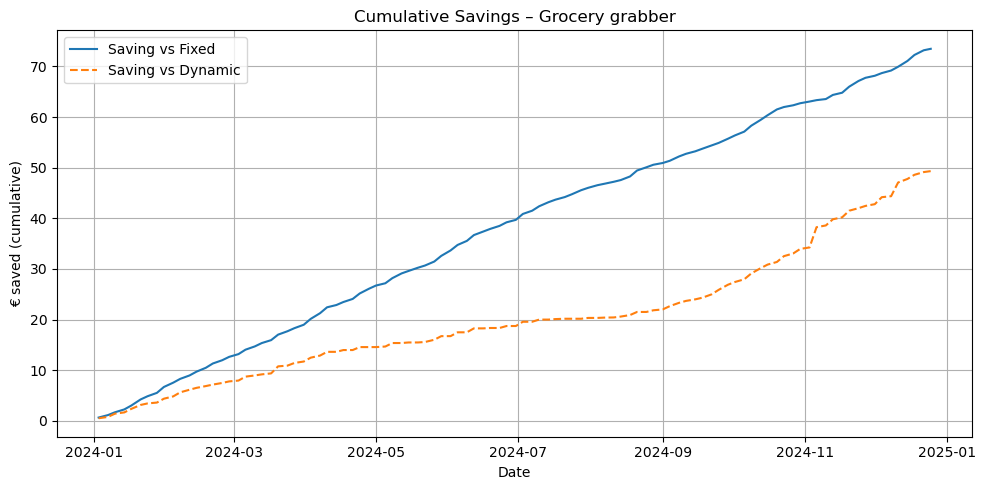

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart of the total yearly costs
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = np.arange(len(df_results))


# Draw bars
bars_fixed = plt.bar(x - bar_width, df_results["Total fixed (€)"], width=bar_width, label="Fixed price")
bars_dyn = plt.bar(x, df_results["Total dynamic (€)"], width=bar_width, label="Dynamic (non-optimized)")
bars_opt = plt.bar(x + bar_width, df_results["Total optimized (€)"], width=bar_width, label="Optimized")

# Annotate bars with their value
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,  # x-position (center of bar)
            height + 0.02 * max(df_results["Total fixed (€)"]),  # y-position slightly above bar
            f"{height:.0f}",  # rounded to nearest euro
            ha="center", va="bottom", fontsize=9, rotation=0
        )

annotate_bars(bars_fixed)
annotate_bars(bars_dyn)
annotate_bars(bars_opt)

plt.xticks(x, df_results["Scenario"], rotation=20)
plt.ylabel("Total yearly costs (€)")
plt.title("Comparison of yearly charging costs per scenario")
plt.legend()
plt.tight_layout()
plt.show()

# Histogram of the optimal charging hours in a day, averaged over the year.
plt.figure(figsize=(10, 6))
all_hours = []
for r in results:
    all_hours.extend(r["Optimized hours"])
plt.hist(all_hours, bins=range(0, 25), edgecolor="black", align="left", color="skyblue")
plt.xlabel("Hour of day")
plt.ylabel("Frequency of charging")
plt.title("Distribution of optimal charging hours (aggregated over all scenarios)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# cumulative costs and savings graphs per scenario
def plot_cumulative_costs(df_daily, scenario_name):
    df_s = df_daily[df_daily["scenario"] == scenario_name].sort_values("date")
    df_s["cum_fixed"]   = df_s["cost_fixed"].cumsum()
    df_s["cum_dynamic"] = df_s["cost_dynamic"].cumsum()
    if "cost_optimized" in df_s.columns:
        df_s["cum_optimized"] = df_s["cost_optimized"].cumsum()
    df_s["cum_saving_dyn"] = df_s["cum_dynamic"] - df_s["cum_optimized"]
    df_s["cum_saving_fix"] = df_s["cum_fixed"] - df_s["cum_optimized"]

    # cumulative costs plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_s["date"], df_s["cum_fixed"],   label="Fixed")
    ax.plot(df_s["date"], df_s["cum_dynamic"], label="Dynamic (non-opt)")
    ax.plot(df_s["date"], df_s["cum_optimized"], label="Optimized")
    ax.set_title(f"Cumulative costs in 2024 – {scenario_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("€ cumulative")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # cumulative savings plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_s["date"], df_s["cum_saving_fix"], label="Saving vs Fixed")
    ax.plot(df_s["date"], df_s["cum_saving_dyn"], label="Saving vs Dynamic", linestyle="--")
    ax.set_title(f"Cumulative Savings – {scenario_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("€ saved (cumulative)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Collect all daily data
df_all_daily = pd.concat([r["Daily data"] for r in results])

# Plot for each scenario
for scenario in df_all_daily["scenario"].unique():
    plot_cumulative_costs(df_all_daily, scenario)